## Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.


In this homework, we will use the lead scoring dataset. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv).


In this dataset our desired target for classification task will be `converted` variable - has the client signed up to the platform or not. 

### Data preparation

* Check if the missing values are presented in the features.
* If there are missing values:
    * For caterogiral features, replace them with 'NA'
    * For numerical features, replace with with 0.0 


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [ ]:
# !wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

--2025-10-22 16:22:36--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.02s   

2025-10-22 16:22:36 (3.72 MB/s) - ‘course_lead_scoring.csv’ saved [80876/80876]



In [15]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [6]:
df = pd.read_csv('course_lead_scoring.csv')
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [8]:
categorical = []
numerical = []

for col, dtype in df.dtypes.items():
    if dtype == 'object':
        categorical.append(col)
    else:  
        numerical.append(col)
print(categorical)
print(numerical)


['lead_source', 'industry', 'employment_status', 'location']
['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score', 'converted']


In [11]:
df[categorical].isnull().sum(),df[numerical].isnull().sum()


(lead_source          128
 industry             134
 employment_status    100
 location              63
 dtype: int64,
 number_of_courses_viewed      0
 annual_income               181
 interaction_count             0
 lead_score                    0
 converted                     0
 dtype: int64)

In [13]:
df[categorical] = df[categorical].fillna('NA')
df[numerical] = df[numerical].fillna(0)



In [14]:
df[categorical].isnull().sum(),df[numerical].isnull().sum()

(lead_source          0
 industry             0
 employment_status    0
 location             0
 dtype: int64,
 number_of_courses_viewed    0
 annual_income               0
 interaction_count           0
 lead_score                  0
 converted                   0
 dtype: int64)

In [16]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

len(df_train), len(df_val), len(df_test)

(876, 293, 293)

In [18]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']


### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `lead_score`
- `number_of_courses_viewed`
- `interaction_count`
- `annual_income`

ANSWER: `number_of_courses_viewed`


In [19]:
from sklearn.metrics import roc_auc_score

In [25]:
for col in numerical[0:4]:
    score = roc_auc_score(y_train, df_train[col])
    print(col, ': ', score)

number_of_courses_viewed :  0.7635680590007088
annual_income :  0.5519578313253012
interaction_count :  0.738270176293409
lead_score :  0.6144993577250176



### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72
- 0.92

ANSWER: 0.72 (0.817)

In [26]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [29]:
# One hot encoding
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical[0:4]].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical[0:4]].to_dict(orient='records')
X_val = dv.transform(val_dict)

# Train logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
# solver='lbfgs' is the default solver in newer version of sklearn
# for older versions, you need to specify it explicitly
model.fit(X_train, y_train)

# Predicting y values
y_pred = model.predict_proba(X_val)[:, 1]

In [30]:
score = roc_auc_score(y_val, y_pred)
score

0.8171316268814112


### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* 0.745

ANSWER: 0.545

In [43]:
thresholds = np.arange(0,1.01,0.01)

precision = []
recall = []

for t in thresholds:

    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp / (tp + fp)
    r = tp / (tp + fn)

    precision.append(p)
    recall.append(r)



/tmp/ipykernel_3986/4208992533.py:20: RuntimeWarning: invalid value encountered in scalar divide
  p = tp / (tp + fp)


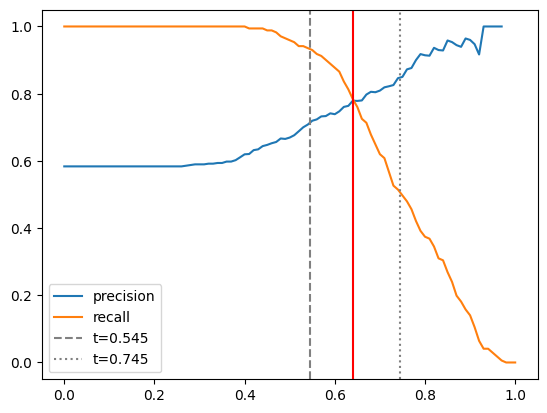

In [93]:
plt.plot(thresholds,precision, label = 'precision')
plt.plot(thresholds, recall, label='recall')
plt.axvline(x=0.545, ls = '--', color='gray', label='t=0.545')
plt.axvline(x=0.745, ls = ':', color='gray', label='t=0.745')
plt.axvline(x=0.640, color = 'red')
plt.legend()


### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54
- 0.74

ANSWER: 0.54

In [77]:
f1 = []
for i in np.arange(0,len(precision)):
    f1.append(2*precision[i]*recall[i]/(precision[i]+recall[i]))

max(f1)


np.float64(0.8124999999999999)

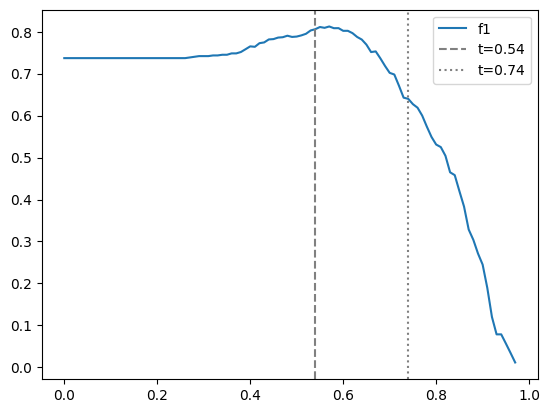

In [92]:
plt.plot(thresholds, f1, label='f1')
plt.axvline(x=0.54, ls = '--', color='gray', label='t=0.54')
plt.axvline(x=0.74, ls = ':', color='gray', label='t=0.74')
plt.legend()


### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.36


### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.